Setup

In [1]:
# === 0) Setup ===
# !pip install -q sentence-transformers numpy scipy scikit-learn plotly pandas matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sentence_transformers import SentenceTransformer

np.set_printoptions(precision=4, suppress=True)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

RNG = np.random.default_rng(42)
print("Libraries ready.")


Libraries ready.


Config

In [2]:
# === 1) Config ===
DATA_NORMAL = "/content/prompts_normal.txt"
DATA_ANOMALOUS = "/content/prompts_anomalous.txt"

EMBED_MODEL = "all-MiniLM-L6-v2"   # 384-dimensional
ALPHA = 0.01                       # χ² (1−α) confidence
USE_ROBUST_COV = True              # Ledoit–Wolf
AUGMENT_SYNTHETIC_NORMAL = 0       # optional extra simulated normals
AUGMENT_SYNTHETIC_ANOM   = 0       # optional extra simulated anomalies

TSNE_SUBSAMPLE = 2000
TSNE_PERPLEXITY = 50

print(f"Config ready | α={ALPHA}, robust_cov={USE_ROBUST_COV}")


Config ready | α=0.01, robust_cov=True


Load Prompt Files

In [3]:
# === 2) Load prompt text files ===
def read_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

prompts_normal = read_lines(DATA_NORMAL)
prompts_anom   = read_lines(DATA_ANOMALOUS)

print(f"Loaded {len(prompts_normal)} normal and {len(prompts_anom)} anomalous prompts.")


Loaded 15 normal and 15 anomalous prompts.


Embed Prompts (SentenceTransformer)

In [4]:
# === 3) Generate real embeddings for prompts ===
embedder = SentenceTransformer(EMBED_MODEL)

emb_norm = embedder.encode(prompts_normal, normalize_embeddings=True, convert_to_numpy=True)
emb_anom = embedder.encode(prompts_anom, normalize_embeddings=True, convert_to_numpy=True)

X_nlp = np.vstack([emb_norm, emb_anom])
y_nlp = np.array([0]*len(emb_norm) + [1]*len(emb_anom))

print("Embeddings ready:", X_nlp.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings ready: (30, 384)


Optional Synthetic Augmentation

In [5]:
# === 4) (Optional) Augment with synthetic embeddings for scale ===
def synth_set(n_norm=0, n_anom=0, dim=384):
    Sigma = np.diag(np.linspace(0.7, 1.3, dim))
    mu_norm = np.zeros(dim)
    mu_anom = np.concatenate([np.ones(dim//2)*3.0, np.zeros(dim - dim//2)])
    Sigma_anom = np.diag(np.concatenate([np.ones(dim//2)*2.5, np.ones(dim - dim//2)*0.8]))
    normal = RNG.multivariate_normal(mu_norm, Sigma, size=n_norm) if n_norm>0 else np.empty((0,dim))
    anom   = RNG.multivariate_normal(mu_anom, Sigma_anom, size=n_anom) if n_anom>0 else np.empty((0,dim))
    Xs = np.vstack([normal, anom]) if n_norm+n_anom>0 else np.empty((0,dim))
    ys = np.array([0]*n_norm + [1]*n_anom) if n_norm+n_anom>0 else np.empty((0,), dtype=int)
    return Xs, ys

X_syn, y_syn = synth_set(AUGMENT_SYNTHETIC_NORMAL, AUGMENT_SYNTHETIC_ANOM, dim=X_nlp.shape[1])
X = np.vstack([X_nlp, X_syn]) if X_syn.size else X_nlp
y_true = np.concatenate([y_nlp, y_syn]) if y_syn.size else y_nlp

print("Final dataset:", X.shape, "labels:", y_true.shape)


Final dataset: (30, 384) labels: (30,)


Fit Covariance on Normal Embeddings

In [6]:
# === 5) Fit covariance on normal-only data ===
X_norm = X[y_true==0]
if USE_ROBUST_COV:
    lw = LedoitWolf().fit(X_norm)
    mu_hat = lw.location_
    Sigma_hat = lw.covariance_
else:
    mu_hat = X_norm.mean(axis=0)
    Sigma_hat = np.cov(X_norm, rowvar=False)

eps = 1e-8
Sigma_inv = np.linalg.inv(Sigma_hat + eps*np.eye(Sigma_hat.shape[0]))
print("Fitted Ledoit–Wolf covariance | μ:", mu_hat.shape, "Σ:", Sigma_hat.shape)


Fitted Ledoit–Wolf covariance | μ: (384,) Σ: (384, 384)


Mahalanobis Distance & χ² Threshold

In [7]:
# === 6) Mahalanobis scoring ===
diff = X - mu_hat
maha2 = np.einsum('ij,jk,ik->i', diff, Sigma_inv, diff)
dof = X.shape[1]
chi2_threshold = chi2.ppf(1 - ALPHA, dof)
pred_flag = (maha2 > chi2_threshold).astype(int)
p_right_tail = 1 - chi2.cdf(maha2, dof)

print(f"χ² threshold (α={ALPHA}): {chi2_threshold:.2f}")


χ² threshold (α=0.01): 451.39


Metrics & Histogram

Confusion Matrix (rows=true, cols=pred):
 [[15  0]
 [ 0 15]]

Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        15
     Anomaly       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



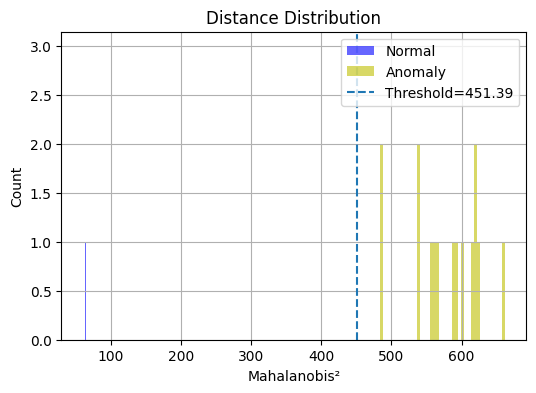

In [15]:
# === 7) Metrics & Histogram ===
cm = confusion_matrix(y_true, pred_flag, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):\n", cm)
print("\nReport:\n", classification_report(y_true, pred_flag, target_names=["Normal","Anomaly"]))

plt.figure()
plt.hist(maha2[y_true==0], bins=40, alpha=0.6, label='Normal', color='b')
plt.hist(maha2[y_true==1], bins=40, alpha=0.6, label='Anomaly', color='y')
plt.axvline(chi2_threshold, linestyle='--', label=f'Threshold={chi2_threshold:.2f}')
plt.xlabel('Mahalanobis²'); plt.ylabel('Count'); plt.title('Distance Distribution')
plt.legend(); plt.show()


PCA (2D Interactive Visualization)

In [9]:
# === 8) PCA (interactive) ===
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)
fig = px.scatter(
    x=X2[:,0], y=X2[:,1],
    color=np.where(pred_flag==1, "Flagged", "Not Flagged"),
    symbol=np.where(y_true==1, "Anomaly", "Normal"),
    title="PCA Projection: Flagged vs Ground Truth",
    labels={"x":"PC1","y":"PC2"}
)
fig.show()


QQ-Plot and ECDF vs χ²

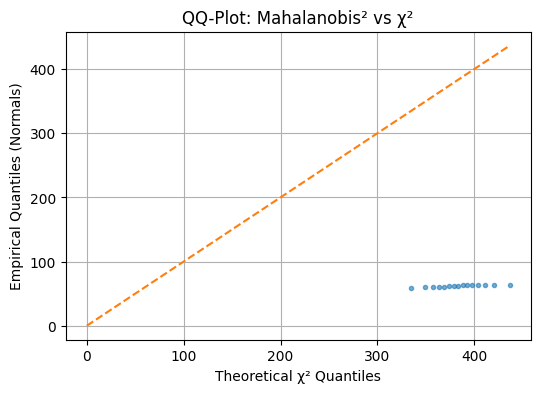

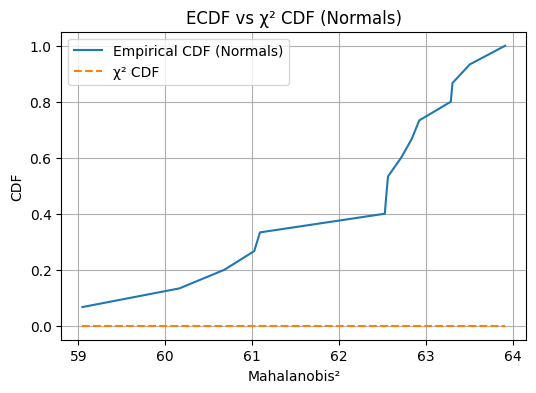

In [10]:
# === 9) QQ-Plot and ECDF ===
emp = np.sort(maha2[y_true==0])
qs = (np.arange(1, emp.size+1) - 0.5) / emp.size
theo = chi2.ppf(qs, dof)

plt.plot(theo, emp, '.', alpha=0.6)
mx = max(theo.max(), emp.max())
plt.plot([0, mx], [0, mx], '--')
plt.xlabel('Theoretical χ² Quantiles'); plt.ylabel('Empirical Quantiles (Normals)')
plt.title('QQ-Plot: Mahalanobis² vs χ²')
plt.show()

emp_sorted = emp
ecdf_y = np.arange(1, emp_sorted.size+1) / emp_sorted.size
theo_cdf = chi2.cdf(emp_sorted, dof)

plt.plot(emp_sorted, ecdf_y, label='Empirical CDF (Normals)')
plt.plot(emp_sorted, theo_cdf, '--', label='χ² CDF')
plt.xlabel('Mahalanobis²'); plt.ylabel('CDF'); plt.title('ECDF vs χ² CDF (Normals)')
plt.legend(); plt.show()


Threshold Sweep

,alpha,threshold,TPR,FPR
0,0.100,419.916074,1.0,0.0
1,0.050,430.691918,1.0,0.0
2,0.020,443.036677,1.0,0.0
3,0.010,451.394735,1.0,0.0
4,0.005,459.134293,1.0,0.0
5,0.001,475.366301,1.0,0.0


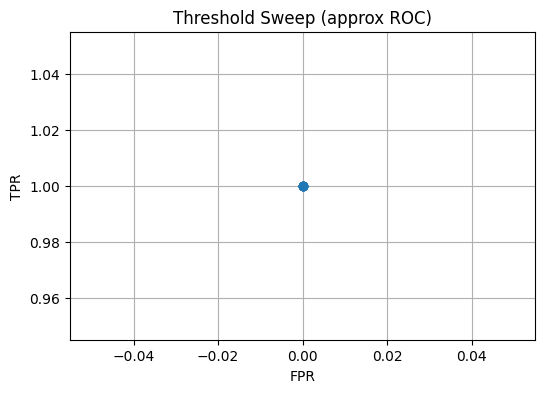

In [11]:
# === 10) Threshold sweep (TPR/FPR trade-off) ===
alphas = [0.10, 0.05, 0.02, 0.01, 0.005, 0.001]
rows = []
for a in alphas:
    thr = chi2.ppf(1 - a, dof)
    pf = (maha2 > thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pf, labels=[0,1]).ravel()
    tpr = tp/(tp+fn+1e-9); fpr = fp/(fp+tn+1e-9)
    rows.append({"alpha":a, "threshold":thr, "TPR":tpr, "FPR":fpr})

df_sweep = pd.DataFrame(rows)
display(df_sweep)

plt.plot(df_sweep["FPR"], df_sweep["TPR"], marker='o')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Threshold Sweep (approx ROC)")
plt.show()


t-SNE Visualization

In [16]:
# === 11) t-SNE (subsampled, interactive) ===
if TSNE_SUBSAMPLE is not None and TSNE_SUBSAMPLE < X.shape[0]:
    idx = RNG.choice(X.shape[0], size=TSNE_SUBSAMPLE, replace=False)
    X_ts, pf_ts, y_ts = X[idx], pred_flag[idx], y_true[idx]
else:
    X_ts, pf_ts, y_ts = X, pred_flag, y_true

# 🔧 Auto-adjust perplexity so it's always valid
perplexity = min(TSNE_PERPLEXITY, max(5, X_ts.shape[0] // 3))
print(f"t-SNE running with perplexity={perplexity} on {X_ts.shape[0]} samples...")

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto"
)

X_tsne = tsne.fit_transform(X_ts)

fig_tsne = px.scatter(
    x=X_tsne[:,0], y=X_tsne[:,1],
    color=np.where(pf_ts==1, "Flagged", "Not Flagged"),
    symbol=np.where(y_ts==1, "Anomaly", "Normal"),
    title=f"t-SNE Projection (n={X_ts.shape[0]}, perplexity={perplexity})",
    labels={"x":"tSNE-1","y":"tSNE-2"}
)
fig_tsne.show()


t-SNE running with perplexity=10 on 30 samples...


Bayesian Posterior (PPV)

In [17]:
# === 12) Bayesian PPV ===
tn, fp, fn, tp = confusion_matrix(y_true, pred_flag, labels=[0,1]).ravel()
TPR = tp / (tp + fn + 1e-9)
FPR = fp / (fp + tn + 1e-9)

prior_anom = 0.02
PPV = (TPR * prior_anom) / (TPR * prior_anom + FPR * (1 - prior_anom) + 1e-12)
print(f"TPR={TPR:.3f}, FPR={FPR:.3f}, Prior={prior_anom:.3f} ⇒ PPV={PPV:.3f}")


TPR=1.000, FPR=0.000, Prior=0.020 ⇒ PPV=1.000


xAI: Per-Dimension Contributions

In [18]:
# === 13) xAI: Per-dimension contributions ===
per_dim_contrib = diff * (diff @ Sigma_inv.T)
per_dim_contrib = np.clip(per_dim_contrib, a_min=0, a_max=None)
scale = (per_dim_contrib.sum(axis=1, keepdims=True) + 1e-12)
per_dim_contrib_norm = per_dim_contrib / scale

flag_idx = np.where(pred_flag==1)[0][:5]
for idx in flag_idx:
    top_dims = per_dim_contrib_norm[idx].argsort()[::-1][:5]
    shares = per_dim_contrib_norm[idx, top_dims]
    print(f"Sample {idx} | D²={maha2[idx]:.2f} | top dims {top_dims.tolist()} | shares {shares.round(3)}")


Sample 15 | D²=557.24 | top dims [255, 91, 65, 228, 249] | shares [0.026 0.024 0.02  0.019 0.018]
Sample 16 | D²=539.18 | top dims [232, 2, 42, 180, 373] | shares [0.039 0.031 0.022 0.017 0.017]
Sample 17 | D²=615.50 | top dims [85, 284, 379, 174, 149] | shares [0.032 0.022 0.022 0.018 0.016]
Sample 18 | D²=662.24 | top dims [364, 50, 141, 85, 134] | shares [0.017 0.017 0.017 0.016 0.015]
Sample 19 | D²=566.25 | top dims [327, 32, 336, 244, 270] | shares [0.032 0.022 0.021 0.018 0.017]


xAI Bar Chart

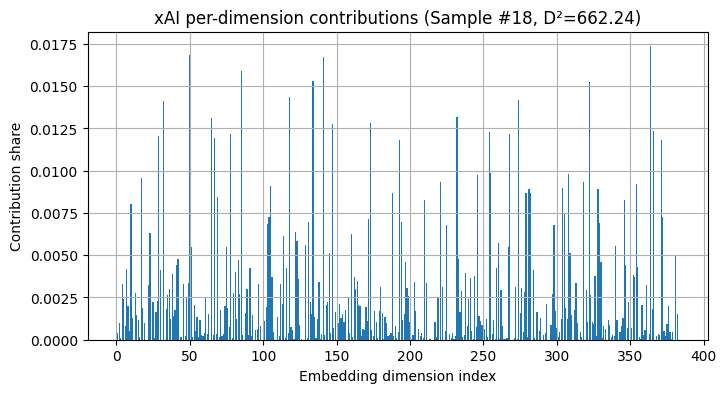

In [19]:
# === 14) xAI bar chart for most anomalous sample ===
flagged = np.where(pred_flag==1)[0]
if flagged.size > 0:
    worst = flagged[np.argmax(maha2[flagged])]
    contribs = per_dim_contrib_norm[worst]
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(X.shape[1]), contribs)
    plt.title(f"xAI per-dimension contributions (Sample #{worst}, D²={maha2[worst]:.2f})")
    plt.xlabel("Embedding dimension index"); plt.ylabel("Contribution share")
    plt.show()
else:
    print("No flagged samples; adjust α or data parameters.")


Save Artifacts (for GitHub repo)

In [20]:
# === 15) Export embeddings & results for GitHub ===
os.makedirs("/content/outputs", exist_ok=True)

np.save("/content/outputs/embeddings.npy", X)
np.save("/content/outputs/labels.npy", y_true)
pd.DataFrame({"maha2":maha2, "pred_flag":pred_flag, "y_true":y_true}).to_csv("/content/outputs/scores.csv", index=False)

with open("/content/outputs/README_RUN.txt", "w") as f:
    f.write(
        "Artifacts generated by Spectra AI Anomaly Prompt Detection\n"
        f"- Embedding model: {EMBED_MODEL}\n"
        f"- Robust covariance: {USE_ROBUST_COV}\n"
        f"- Alpha (χ²): {ALPHA}\n"
        f"- Data: {len(prompts_normal)} normal, {len(prompts_anom)} anomalous prompts\n"
    )

print("✅ Outputs saved to /content/outputs/. Commit these to your GitHub repo.")


✅ Outputs saved to /content/outputs/. Commit these to your GitHub repo.
